# FMU Data Acquisition Code

In [1]:
from serial import *
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
from threading import Thread

## Connect

In [2]:
COM = 'COM4'# /dev/ttyACM0 (Linux)
BAUD = 9600

last_received = ''
stop_threading = False

def receiving(ser):
    global last_received, stop_threading

    buffer_string = ''
    while True:
        buffer_string = buffer_string + str(ser.read(ser.inWaiting()),'utf-8')
        if '\n' in buffer_string:
            lines = buffer_string.split('\n') # Guaranteed to have at least 2 entries
            last_received = lines[-2]
            #If the Arduino sends lots of empty lines, you'll lose the
            #last filled line, so you could make the above statement conditional
            #like so: if lines[-2]: last_received = lines[-2]
            buffer_string = lines[-1]
        if stop_threading==True:
            break

COM = 'COM4'

ser = Serial(
    port=COM,
    baudrate=9600,
    bytesize=EIGHTBITS,
    parity=PARITY_NONE,
    stopbits=STOPBITS_ONE,
    timeout=0.1,
    xonxoff=0,
    rtscts=0,
    interCharTimeout=None
)

thread=Thread(target=receiving, args=(ser,))
thread.start()



print('Waiting for device')
print(ser.name)
# time.sleep(7)
for i in range(7):
    sys.stdout.write("\r"+str(i+1)+" sec")
    time.sleep(1)
print("\nConnection Established!")

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

Waiting for device
COM4
7 sec
Connection Established!


## Acquisition

Starting measurement...
Measuring: 100% 10.0 seconds passed
Measurement finished.


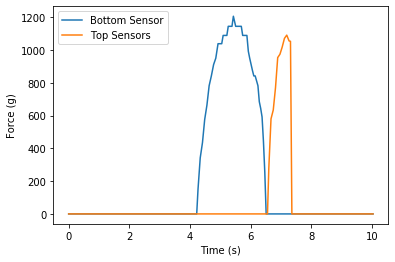

In [4]:
# timeFinal = float(input("Duration of acquisition:"))  # seconds
timeFinal = 10  # seconds


sensorValue=[]
sensorValue2=[]
timeValue=[]

sensorValue.clear()
sensorValue2.clear()
timeValue.clear()

timeInitial=time.time()
timePassed=0

i=0
timeValue_last=0

print("Starting measurement...")

while (timePassed<timeFinal):
    timeCurrent = time.time()
    timePassed=timeCurrent-timeInitial
    
    
    serialValue = last_received.split() #Capture serial output as a decoded string
    
    if float(serialValue[0])!=timeValue_last:
        if (len(serialValue) == 3):
            if is_number(serialValue[0] and serialValue[1]):

                timeValue.append(float(serialValue[0]))
                sensorValue.append(float(serialValue[1]))
                sensorValue2.append(float(serialValue[2]))
                timeValue_last=float(serialValue[0])

    sys.stdout.write("\r"+"Measuring: " + str("{0:.0f}".format(np.floor(100*timePassed/timeFinal)))+"% "+str("{0:.1f}".format(timePassed))+" seconds passed")

print("\nMeasurement finished.")

sensorValue = np.array(sensorValue)
sensorValue2 = np.array(sensorValue2)
# sensorValue3 = np.array(sensorValue3)
timeValue = np.array(timeValue)
timeValue = timeValue-np.ones((len(timeValue),))*timeValue[0]
timeValue=timeValue*1E-3		#put in seconds (original in mili)


fig=plt.gcf()
plt.clf()
fig.tight_layout()
plt.ylabel("Force (g)")
plt.xlabel("Time (s)")
plt.plot(timeValue, sensorValue, label="Bottom Sensor")
plt.plot(timeValue, sensorValue2, label="Top Sensors")
plt.legend()


# Save

!!! **IMPORTANT**: Change *numberOfSample* otherwise files get overwritten

In [5]:
wafer = "test-sultan"
numberOfSample = ""

fname = wafer+"-"+str(numberOfSample)
# fname="test"

try:
    np.savetxt("sample-"+fname+".csv",np.c_[timeValue,sensorValue,sensorValue2],delimiter=",")	#np.c_[] to put lines in columns in csv
    fig.savefig("sample-"+fname+".png",dpi=120)
    print("Files saved!")
except ValueError:
    print(ValueError)

Files saved!


# Test Variables

3528367	0.00	0.00


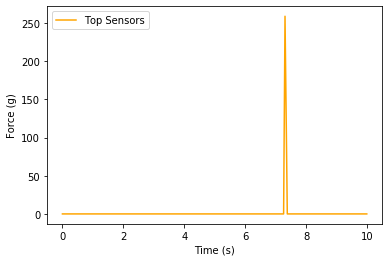

In [16]:
# print(timeValue[1000])
print(last_received)

plt.clf()
fig=plt.gcf()

fig.tight_layout()
plt.ylabel("Force (g)")
plt.xlabel("Time (s)")
# plt.plot(timeValue, sensorValue, label="Bottom Sensor")
plt.plot(timeValue, sensorValue2,color='orange', label="Top Sensors")
plt.legend()

# Close Connection COM4

In [6]:
stop_threading=True
thread.join()
sys.stdout.write("\rThread killed!")
ser.close()

Thread killed!